In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# ===============================
# 2. Data Collection
# ===============================
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2015-01-01", end="2025-01-01")
data.reset_index(inplace=True)
print("Data sample:")
data.head()

C:\Users\Anuj Bhole\AppData\Local\Temp\ipykernel_21844\939889416.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_symbol, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Data sample:


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2015-01-02,24.261049,24.729272,23.821673,24.718176,212818400
1,2015-01-05,23.577576,24.110152,23.391175,24.030265,257142000
2,2015-01-06,23.579800,23.839430,23.218091,23.641933,263188400
3,2015-01-07,23.910437,24.010294,23.677434,23.788387,160423600
4,2015-01-08,24.829128,24.886824,24.121246,24.238858,237458000


In [3]:
# ===============================
# 3. Stock Price Prediction (Regression)
# ===============================
# Focus on 'Close' price
close_data = data[['Date', 'Close']]
print(close_data.columns)
close_data.head()

MultiIndex([( 'Date',     ''),
            ('Close', 'AAPL')],
           names=['Price', 'Ticker'])


Price,Date,Close
Ticker,,AAPL
0,2015-01-02,24.261049
1,2015-01-05,23.577576
2,2015-01-06,23.579800
3,2015-01-07,23.910437
4,2015-01-08,24.829128


In [4]:
# Preprocess data
dataset_ex_df = close_data.copy()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df.head()

Price,Close
Ticker,AAPL
Date,
2015-01-02,24.261049
2015-01-05,23.577576
2015-01-06,23.579800
2015-01-07,23.910437
2015-01-08,24.829128


In [5]:
# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(dataset_ex_df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10432.729, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10428.911, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10430.475, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10430.450, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10432.365, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10430.912, Time=0.51 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.714 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2516
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5212.455
Date:                Sun, 31 Aug 2025   AIC                          10428.911
Time:                        17:26:01   BIC                          10440.571
Sample:                             0   HQIC                         10433.143
    

In [6]:
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df['Close'].values 
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = []
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

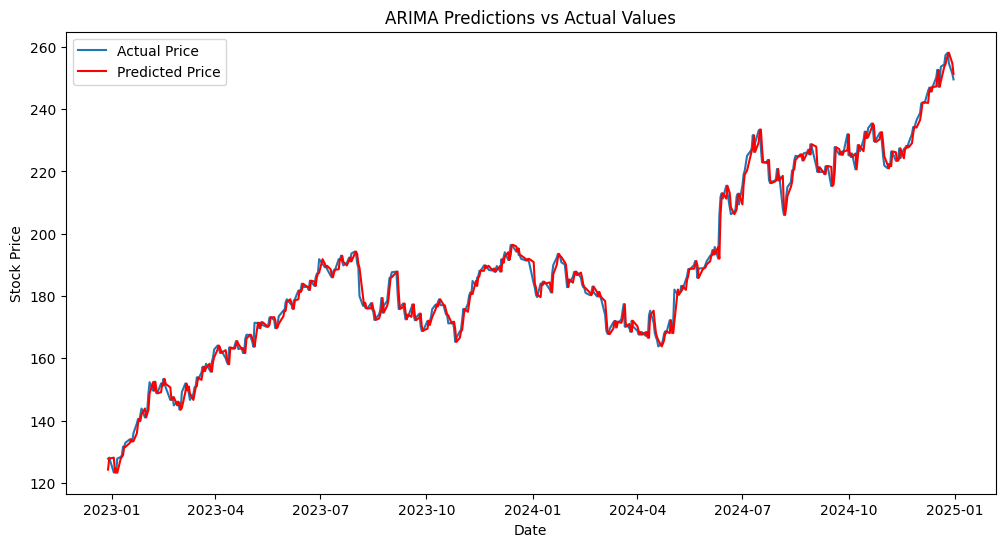

In [7]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Actual Price')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted Price')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [8]:
# Metrics
rmse = math.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print(f"ARIMA RMSE: {rmse}, MAE: {mae}")

ARIMA RMSE: 2.542887452843282, MAE: 1.8878050607348245


In [9]:
# --- Prophet ---
#close_data = data[['Date', 'Close']].copy()
#prophet_data = close_data.rename(columns={'Date':'ds','Close':'y'})
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2023-01-01", end="2025-01-01")
data.reset_index(inplace=True)
df = data[['Date', 'Close']].copy()
prophet_data = pd.DataFrame({
    'ds': pd.to_datetime(df['Date']),
    'y': df['Close'].values.ravel()  # ensure 1D
})
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)

C:\Users\Anuj Bhole\AppData\Local\Temp\ipykernel_21844\2744617593.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_symbol, start="2023-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1] done processing


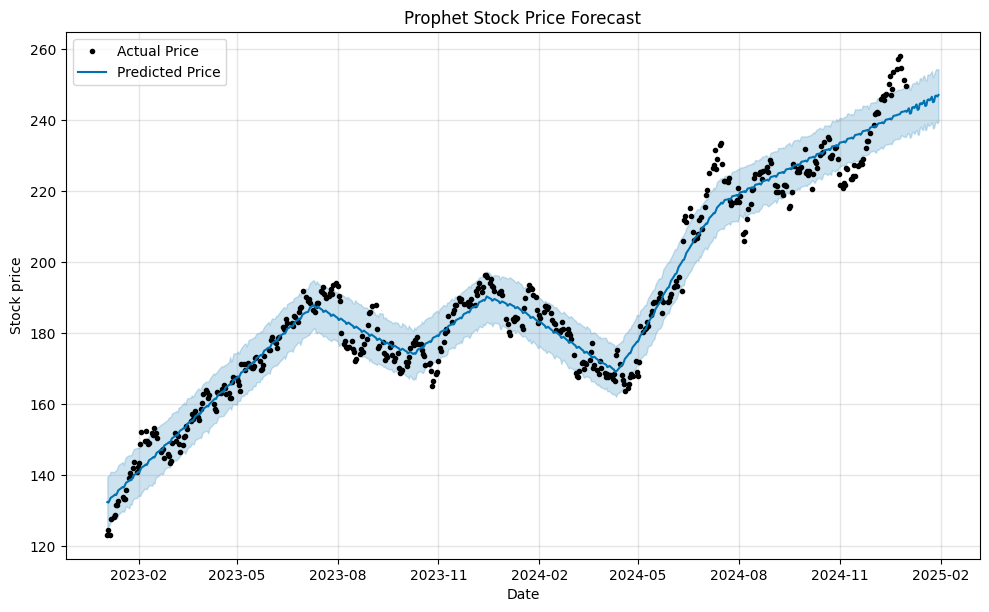

In [10]:
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)
fig = prophet_model.plot(forecast)
plt.title('Prophet Stock Price Forecast')
ax = fig.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Stock price")
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

In [16]:
# Merge actuals and predictions for easy comparison
evaluation_df = forecast.set_index('ds')[['yhat']].join(prophet_data.set_index('ds').y).reset_index()

# Calculate Squared Errors
evaluation_df['squared_error'] = (evaluation_df['y'] - evaluation_df['yhat'])**2

mse = np.mean(evaluation_df['squared_error'])

# Calculate RMSE
rmse = np.sqrt(mse)

# Align actual vs predicted (on the same dates)
df_merged = prophet_data.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate MAE
mae = mean_absolute_error(df_merged['y'], df_merged['yhat'])

print(f"ARIMA RMSE: {rmse}, MAE: {mae}")

ARIMA RMSE: 5.435960486497058, MAE: 4.2774616206511755


In [17]:
# --- LSTM Regression ---
ts = close_data.set_index('Date')['Close']
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(ts.values.reshape(-1,1))

# Sequence creation
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i,0])
        y.append(data[i,0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_close, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [18]:
# Train-test split
split = int(0.8*len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [19]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


C:\Users\Anuj Bhole\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0211
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.7905e-04
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.2902e-04
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.7217e-04
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.6363e-04
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.3966e-04
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.2723e-04
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.3759e-04
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.4308e-04
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.0227e-04
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.4817e-04
Epoch 15/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [20]:
# Predict
pred_prices = lstm_model.predict(X_test)
pred_prices = scaler.inverse_transform(pred_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


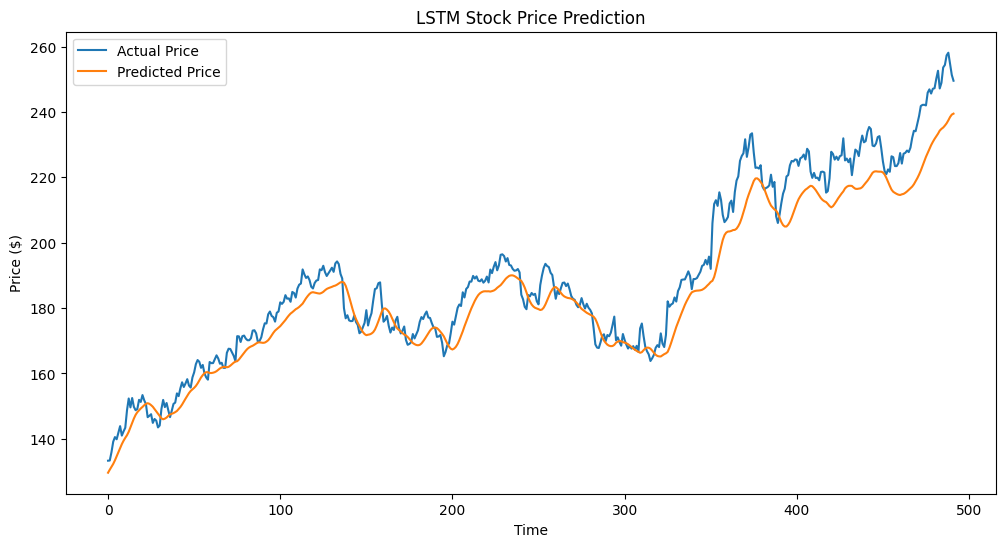

In [21]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(real_prices, label='Actual Price')
plt.plot(pred_prices, label='Predicted Price')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [22]:
# Metrics
rmse = math.sqrt(mean_squared_error(real_prices, pred_prices))
mae = mean_absolute_error(real_prices, pred_prices)
print(f"LSTM RMSE: {rmse}, MAE: {mae}")

LSTM RMSE: 8.083537421503978, MAE: 6.415048025487884




### Step 1: Data Preparation

Prophet requires a very specific structure for the dataset. You take the stock price data and reduce it to just two columns:

* One column containing dates (this becomes the `ds` column).
* One column containing the closing price values (this becomes the `y` column).

The date values must be in a proper datetime format, and the price values must be numeric so Prophet can model them.

---

### Step 2: Initializing the Model

Once the data is ready, you create a Prophet model. By default, Prophet models trend and yearly seasonality. You can also enable or disable other seasonalities, such as daily or weekly, depending on the type of data. Since stock data often has daily movement, daily seasonality can be turned on.

---

### Step--

# 🔹 1. ARIMA (Autoregressive Integrated Moving Average)

### Step 1: Stationarity Check

ARIMA works best on **stationary time series** (no trend, constant mean/variance over time).
So the first step is to check whether the stock closing price series is stationary. If not, you apply differencing to remove trends and make it stationary.

### Step 2: Model Components

ARIMA is built from three terms:

* **AR (p)** – the autoregressive part, using past values to predict the future.
* **I (d)** – the integrated part, which involves differencing to make the series stationary.
* **MA (q)** – the moving average part, which uses past forecast errors to improve predictions.

So, the model is denoted ARIMA(p, d, q).

### Step 3: Model Fitting

You choose p, d, q parameters (often using techniques like ACF/PACF plots or automated search). Then, ARIMA learns the relationship between past values and errors to predict future stock prices.

### Step 4: Forecasting

Once trained, ARIMA produces forecasts for the next n steps. Since ARIMA is linear, the forecast is interpretable but may not capture very complex patterns in stock data.

---

# 🔹 2. LSTM (Long Short-Term Memory Networks)

### Step 1: Data Preparation

Stock prices are sequential, so LSTM is ideal because it captures long-term dependencies.

* The closing prices are normalized (scaled to a small range like \[0,1]).
* Data is split into training and testing sets.
* The series is then converted into input-output pairs, where past `n` days are used to predict the next day’s price.

### Step 2: LSTM Architecture

LSTM is a type of recurrent neural network (RNN) that avoids the vanishing gradient problem by using **memory cells and gates**. These gates decide:

* What to keep from the past (long-term memory).
* What to forget (irrelevant history).
* What new information to add.

This makes LSTMs powerful for time-series forecasting compared to ARIMA.

### Step 3: Model Training

The training process involves feeding the sequential input data (sliding windows of stock prices) into the LSTM layers. The network learns patterns of price movement, including non-linear ones.

### Step 4: Forecasting

After training, the model is tested on unseen data. The predictions are then inverse-transformed (back to the original scale).
Unlike ARIMA or Prophet, LSTM can capture highly non-linear relationships and complex temporal dynamics, making it strong for stock data but less interpretable.

---

# 🔹 3. Prophet (by Facebook/Meta)

### Step 1: Data Preparation

The dataset is simplified into two columns:

* `ds`: dates in datetime format.
* `y`: closing prices (numeric).

### Step 2: Model Components

Prophet models time series as a sum of:

1. **Trend** – long-term movement (growth or decline).
2. **Seasonality** – repeating cycles (weekly, yearly, daily).
3. **Holidays/Events** – special dates that affect the time series (optional).

### Step 3: Model Training

When fitting, Prophet automatically detects trend and seasonality patterns. It uses an additive model where these components are combined to explain the stock price movements.

### Step 4: Forecasting

You extend the timeline into the future (e.g., next 30 days). Prophet generates predictions for those dates, along with uncertainty intervals.

### Step 5: Visualization

Prophet provides clear plots:

* Forecast with actual vs predicted values.
* Component plots for trend and seasonality.

Prophet is interpretable and fast but may not capture very sudden or highly non-linear movements compared to LSTM.

---

# 🔹 Comparison of the Three Models

| Model       | Strengths                                                                 | Weaknesses                                                         |
| ----------- | ------------------------------------------------------------------------- | ------------------------------------------------------------------ |
| **ARIMA**   | Good for linear, stationary series. Interpretable.                        | Struggles with non-linear patterns. Requires manual tuning.        |
| **LSTM**    | Captures complex, non-linear dependencies. Great for long-term sequences. | Requires large data, more computational power, less interpretable. |
| **Prophet** | Simple to use, interpretable, handles trend + o also give you a **final conclusion section** on how to compare results and decide which model performs best?

trend or seasonality.

---

### Step 4: Creating a Future Timeline

After the model has been trained, you create a new timeline that extends beyond your dataset. For example, if your dataset ends in December 2023, you might generate 30 more days into January 2024. This timeline serves as the input for prediction.

---

### Step 5: Making Forecasts

Prophet uses the trained model to generate predicted values for both the historical period (to validate performance) and the future period (to provide forecasts). Alongside the predicted values, Prophet also calculates confidence intervals, showing the uncertainty range around each forecasted point.

---

### Step 6: Visualization

Finally, Prophet provides two useful plots:

* The forecast plot, which shows the actual past data, the predicted values, and the uncertainty bands.
* The components plot, which separately shows how trend, weekly seasonality, yearly seasonality, ain **ARIMA** in the same structured step-by-step way?




# 🔹 Final Conclusion: Comparing ARIMA, LSTM, and Prophet

Once you train and forecast using **ARIMA, LSTM, and Prophet**, you’ll need to evaluate which model works best for your stock price data. This involves both **quantitative evaluation** and **qualitative interpretation**.

---

## 1. Quantitative Evaluation (Metrics)

You measure prediction accuracy using error metrics:

* **MAE (Mean Absolute Error):** Average absolute difference between actual and predicted prices. Lower is better.
* **RMSE (Root Mean Squared Error):** Penalizes larger errors more than MAE. Lower is better.
* **MAPE (Mean Absolute Percentage Error):** Useful when you want relative error (%).

By comparing these metrics across models, you can objectively say which model predicts prices more accurately.

---

## 2. Qualitative Evaluation (Behavior & Interpretability)

* **ARIMA**

  * Best if the stock data shows strong autocorrelation and linear trends.
  * Easy to explain and justify predictions.
  * Struggles with sudden market shocks or non-linear behavior.

* **LSTM**

  * Best when the stock shows complex, non-linear, and long-term dependencies.
  * Can adapt to intricate patterns ARIMA/Prophet miss.
  * Harder to interpret (“black box” model).

* **Prophet**

  * Best when the stock has clear **trend + seasonality** (like weekly or yearly effects).
  * Very interpretable (you can directly see trend and seasonal components).
  * Not as flexible for highly irregular or noisy stock data.

---

## 3. Decision Process

* If **interpretability** is most important → Choose **Prophet**.
* If the stock data looks **stationary and mostly linear** → Choose **ARIMA**.
* If the stock shows **complex, non-linear movements** → Choose **LSTM**.
* In practice, you can also **ensemble** them: combine forecasts from ARIMA, LSTM, and Prophet (averaging or stao get morets.

---

## 4. Example Conclusion (for report)

> After evaluating the three models, we find that ARIMA provides a solid baseline for capturing linear dependencies, Prophet is strong in identifying trend and seasonality, while LSTM demonstrates superior performance in capturing complex non-linear patterns. The final choice of model depends on the balance between interpretability and predictive accuracy. For highly volatile stock data, LSTM typically achieves the lowest error, while Prophet offers the clear you can directly use it for your submission/presentation?
